In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
import ee
import pickle
import os
from tqdm import tqdm
from glob import glob
from rasterio.merge import merge
import joblib

import warnings
warnings.filterwarnings("ignore")

# **Prepare the Image for Classification For Single Tile**

In [4]:
band_names_old = [
    'Mean_Monsoon_Rainfall', 'Elevation', 'Slope', 'Aspect', 'Profile_Curve', 'Plan_Curve',
    'TWI', 'SPI', 'STI', 'Flow_Accumulation', 'Drainage_Density', 'Dist_to_Drain', 'HAND_30_100',
    'NDVI', 'LULC', 'Lithology', 'Soil', 'Road_Density', 'Dist_to_Road', 'Pop_Density'
]

In [5]:
image_path = r"/content/drive/MyDrive/Bihar_Flood_Parameters_Image_2/Flood_Parameters_Tiles_6_3.tif"

with rio.open(image_path, 'r') as src:
    image = src.read()
    meta = src.meta

print(image.shape)
meta

(20, 1250, 1695)


{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -inf,
 'width': 1695,
 'height': 1250,
 'count': 20,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]'),
 'transform': Affine(30.0, 0.0, 879870.0,
        0.0, -30.0, 2943960.0)}

In [6]:
# Create an empty pandas dataframe to store the pixel values
image_bands = pd.DataFrame()

# Joining the pixel values of different bands into the dataframe
for i in range(image.shape[0]):
    image_bands[band_names_old[i]] = image[i].flatten()

# Replace the inf value to 0
image_bands.replace([np.inf, -np.inf], 0, inplace=True)

# Replace the -9999 value in the 'Aspect' with -1
image_bands['Aspect'] = image_bands['Aspect'].replace([-9999], -1)
image_bands.replace([-9999], -1, inplace=True)

print(image_bands.shape)
image_bands.head()

(2118750, 20)


,Mean_Monsoon_Rainfall,Elevation,Slope,Aspect,Profile_Curve,Plan_Curve,TWI,SPI,STI,Flow_Accumulation,Drainage_Density,Dist_to_Drain,HAND_30_100,NDVI,LULC,Lithology,Soil,Road_Density,Dist_to_Road,Pop_Density
0,1000.988708,69.0,0.000000,-1.000000,0.000000,0.000000,12.114414,0.000000,32.0,1.609438,1.345119,42.426407,0.0,0.112456,4.0,13.0,8.0,0.054320,6287.272949,2521.15918
1,1000.989746,69.0,0.333020,315.000000,0.000000,0.000000,10.172105,0.707095,32.0,1.386294,1.345362,30.000000,1.0,0.112205,4.0,13.0,8.0,0.054803,6271.722168,2521.15918
2,1000.990723,69.0,2.105281,296.565063,0.237837,-0.086486,15.813718,9965.986328,32.0,9.087381,1.345281,0.000000,4.0,0.129697,4.0,13.0,8.0,0.055266,6256.276855,2521.15918
3,1000.991760,71.0,2.744087,300.963745,-0.074844,0.033264,7.146061,1.457713,0.0,0.000000,1.345050,30.000000,6.0,0.128168,4.0,13.0,8.0,0.055703,6240.937500,2521.15918
4,1000.992798,71.0,2.744087,300.963745,-0.074844,0.033264,7.146061,1.457713,0.0,0.000000,1.345212,42.426407,5.0,0.124619,4.0,13.0,8.0,0.056084,6225.704590,2521.15918


In [7]:
num_bands = ['Elevation', 'Slope', 'Aspect', 'Profile_Curve', 'NDVI', 'Plan_Curve', 'TWI', 'SPI', 'STI',
             'Flow_Accumulation', 'Drainage_Density', 'Dist_to_Drain','Pop_Density','Road_Density',
             'HAND_30_100', 'Dist_to_Road','Mean_Monsoon_Rainfall']

cat_bands = ['LULC', 'Lithology', 'Soil']

band_names_new = num_bands + cat_bands

int_columns = ['Elevation', 'Flow_Accumulation'] + cat_bands
image_bands = image_bands[band_names_new]
image_bands[int_columns] = image_bands[int_columns].astype(int)

print(image_bands.shape)
image_bands.head()

(2118750, 20)


,Elevation,Slope,Aspect,Profile_Curve,NDVI,Plan_Curve,TWI,SPI,STI,Flow_Accumulation,Drainage_Density,Dist_to_Drain,Pop_Density,Road_Density,HAND_30_100,Dist_to_Road,Mean_Monsoon_Rainfall,LULC,Lithology,Soil
0,69,0.000000,-1.000000,0.000000,0.112456,0.000000,12.114414,0.000000,32.0,1,1.345119,42.426407,2521.15918,0.054320,0.0,6287.272949,1000.988708,4,13,8
1,69,0.333020,315.000000,0.000000,0.112205,0.000000,10.172105,0.707095,32.0,1,1.345362,30.000000,2521.15918,0.054803,1.0,6271.722168,1000.989746,4,13,8
2,69,2.105281,296.565063,0.237837,0.129697,-0.086486,15.813718,9965.986328,32.0,9,1.345281,0.000000,2521.15918,0.055266,4.0,6256.276855,1000.990723,4,13,8
3,71,2.744087,300.963745,-0.074844,0.128168,0.033264,7.146061,1.457713,0.0,0,1.345050,30.000000,2521.15918,0.055703,6.0,6240.937500,1000.991760,4,13,8
4,71,2.744087,300.963745,-0.074844,0.124619,0.033264,7.146061,1.457713,0.0,0,1.345212,42.426407,2521.15918,0.056084,5.0,6225.704590,1000.992798,4,13,8


## **Apply Transformer**

In [8]:
# Load the transformer
transformer = pickle.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/transformer.pkl",'rb'))

# Apply the transformer on the image bands
image_bands_transformed = transformer.transform(image_bands)
out_column_names = [col.split("__")[-1] for col in transformer.get_feature_names_out()]
image_bands_transformed = pd.DataFrame(image_bands_transformed, columns=out_column_names)
print(image_bands_transformed.shape)
image_bands_transformed.head()

(2118750, 51)


,Elevation,Slope,Aspect,Profile_Curve,NDVI,Plan_Curve,TWI,SPI,STI,Flow_Accumulation,...,Soil_8,Soil_10,Soil_11,Soil_13,Soil_14,Soil_15,Soil_16,Soil_17,Soil_18,Soil_19
0,-0.188558,-0.627138,-1.094463,-0.127856,-0.892759,-0.126464,0.887146,-0.025671,-0.040946,5.064798,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.188558,-0.455501,1.563370,-0.127856,-0.896735,-0.126464,0.187166,-0.025628,-0.040946,5.064798,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.188558,0.457917,1.408316,1.991928,-0.619785,-1.009269,2.220320,0.580739,-0.040946,47.162708,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.155569,0.787156,1.445313,-0.794921,-0.643995,0.213077,-0.903375,-0.025583,-0.042443,-0.197441,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.155569,0.787156,1.445313,-0.794921,-0.700189,0.213077,-0.903375,-0.025583,-0.042443,-0.197441,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Apply the Model**

In [9]:
selected_features = [
       'Elevation', 'Slope', 'Aspect', 'Profile_Curve', 'NDVI', 'Plan_Curve',
       'TWI', 'SPI', 'STI', 'Drainage_Density', 'Dist_to_Drain', 'Pop_Density',
       'Road_Density', 'HAND_30_100', 'Dist_to_Road', 'Mean_Monsoon_Rainfall',
       'LULC_2', 'LULC_4', 'LULC_5', 'LULC_6', 'LULC_9', 'Lithology_0',
       'Lithology_1', 'Lithology_3', 'Lithology_7', 'Lithology_10',
       'Lithology_12', 'Lithology_13', 'Lithology_14', 'Lithology_15',
       'Lithology_16', 'Lithology_17', 'Soil_1', 'Soil_2', 'Soil_3', 'Soil_4',
       'Soil_6', 'Soil_7', 'Soil_8', 'Soil_10', 'Soil_11', 'Soil_13',
       'Soil_14', 'Soil_15', 'Soil_16', 'Soil_17', 'Soil_18', 'Soil_19'
]
image_bands_transformed = image_bands_transformed[selected_features]
print(image_bands_transformed.shape)
image_bands_transformed.head()

(2118750, 48)


,Elevation,Slope,Aspect,Profile_Curve,NDVI,Plan_Curve,TWI,SPI,STI,Drainage_Density,...,Soil_8,Soil_10,Soil_11,Soil_13,Soil_14,Soil_15,Soil_16,Soil_17,Soil_18,Soil_19
0,-0.188558,-0.627138,-1.094463,-0.127856,-0.892759,-0.126464,0.887146,-0.025671,-0.040946,-0.299819,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.188558,-0.455501,1.563370,-0.127856,-0.896735,-0.126464,0.187166,-0.025628,-0.040946,-0.298983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.188558,0.457917,1.408316,1.991928,-0.619785,-1.009269,2.220320,0.580739,-0.040946,-0.299261,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.155569,0.787156,1.445313,-0.794921,-0.643995,0.213077,-0.903375,-0.025583,-0.042443,-0.300054,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.155569,0.787156,1.445313,-0.794921,-0.700189,0.213077,-0.903375,-0.025583,-0.042443,-0.299498,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
model_path = r"/content/drive/MyDrive/Bihar Project Work/ML_Models/"

ml_model = joblib.load(open(os.path.join(model_path, "updated_Random_Forest.pkl"), 'rb'))
ml_model

RandomForestClassifier(max_depth=5, max_features=0.39198276397961707,
                       min_samples_leaf=35, min_samples_split=87,
                       n_estimators=79, n_jobs=-1, random_state=42)

In [11]:
y_pred = ml_model.predict_proba(image_bands_transformed)[:, 1]

In [12]:
# Reshape the array
y_pred_reshaped = y_pred.reshape((meta['height'], meta['width']))
y_pred_reshaped.shape

(1250, 1695)

In [13]:
import numpy as np
from scipy.signal import fftconvolve

def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    return fftconvolve(padded_array, g, mode='valid')

In [14]:
y_pred_reshaped_smoothed = gaussian_blur(y_pred_reshaped, size=20)

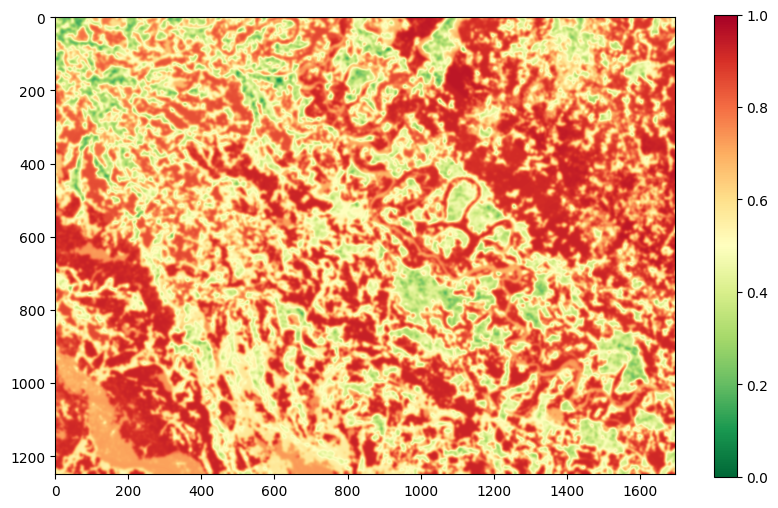

In [15]:
plt.figure(figsize=(10, 6))
plt.imshow(y_pred_reshaped_smoothed, vmin=0, vmax=1, cmap='RdYlGn_r')
plt.colorbar();

## **Download tile**

In [17]:
# Save the image to the file
folder_path = r"/content/drive/MyDrive/Bihar Project Work/Outputs/RF"
file_name = "/RF_Flood_Parameters_Tiles_6_3.tif"
location = folder_path + file_name

output = rio.open(
    location,
    mode='w',
    driver="GTiff",
    width=image.shape[2],
    height=image.shape[1],
    count=1,
    crs= meta['crs'],
    transform=meta['transform'],
    dtype=str(y_pred_reshaped.dtype),
)

output.write(y_pred_reshaped, 1)
output.close()

# **Build algorithm to classify each tile using for loop**

In [22]:
image_folder_path = r"/content/drive/MyDrive/Bihar_Flood_Parameters_Image_2"
output_folder_path = r"/content/drive/MyDrive/Bihar Project Work/Outputs/XGB"

# Load model and transformer
model_path = r"/content/drive/MyDrive/Bihar Project Work/ML_Models"

# Models
ml_model = joblib.load(open(os.path.join(model_path, "updated_XGBoost.pkl"), 'rb'))
transformer = joblib.load(open(os.path.join(model_path, "transformer.pkl"), 'rb'))
# ml_model

# # Loop over all .tif tiles
# for filename in tqdm(os.listdir(image_folder_path)):
#     if filename.endswith(".tif"):
#         print(f"Processing: Stacking_{filename}")
#         image_path = os.path.join(image_folder_path, filename)

#         # Read the image
#         with rio.open(image_path, 'r') as src:
#             image = src.read()
#             meta = src.meta

#         # Flatten bands into DataFrame
#         # Create an empty pandas dataframe to store the pixel values
#         image_bands = pd.DataFrame()

#         # Joining the pixel values of different bands into the dataframe
#         for i in range(image.shape[0]):
#             image_bands[band_names_old[i]] = image[i].flatten()

#         # Replace the inf value to 0
#         image_bands.replace([np.inf, -np.inf], 0, inplace=True)

#         # Replace the -9999 value in the 'Aspect' with -1
#         image_bands['Aspect'] = image_bands['Aspect'].replace([-9999], -1)
#         image_bands.replace([-9999], -1, inplace=True)

#         image_bands = image_bands[band_names_new]
#         image_bands[int_columns] = image_bands[int_columns].astype(int)

#         # Apply the transformer on the image bands
#         image_bands_transformed = transformer.transform(image_bands)
#         out_column_names = [col.split("__")[-1] for col in transformer.get_feature_names_out()]
#         image_bands_transformed = pd.DataFrame(image_bands_transformed, columns=out_column_names)

#         # Select features
#         X = image_bands_transformed[selected_features]

#         # Predict probabilities
#         y_pred = ml_model.predict_proba(X)[:, 1]
#         y_pred_reshaped = y_pred.reshape((meta['height'], meta['width']))

#         # Save output
#         output_file = os.path.join(output_folder_path, f"Stacking_{filename}")
#         with rio.open(
#             output_file,
#             mode='w',
#             driver="GTiff",
#             width=image.shape[2],
#             height=image.shape[1],
#             count=1,
#             crs=meta['crs'],
#             transform=meta['transform'],
#             dtype=y_pred_reshaped.dtype,
#         ) as dst:
#             dst.write(y_pred_reshaped, 1)

#         print(f"Saved: {output_file}")

## **Build algorithm to classify each tile using for loop (Customised)**

In [24]:
# List all files first
all_files = sorted(os.listdir(image_folder_path))  # sort to keep order
tif_files = [f for f in all_files if f.endswith(".tif")]

# Start from 56th tile (index 55 because Python indexing starts at 0)
for filename in tqdm(tif_files):
    print(f"Processing: XGB_{filename}")
    image_path = os.  path.join(image_folder_path, filename)

    # Read the image
    with rio.open(image_path, 'r') as src:
        image = src.read()
        meta = src.meta

    # Flatten bands into DataFrame
    # Create an empty pandas dataframe to store the pixel values
    image_bands = pd.DataFrame()

    # Joining the pixel values of different bands into the dataframe
    for i in range(image.shape[0]):
        image_bands[band_names_old[i]] = image[i].flatten()

    # Replace the inf value to 0
    image_bands.replace([np.inf, -np.inf], 0, inplace=True)

    # Replace the -9999 value in the 'Aspect' with -1
    image_bands['Aspect'] = image_bands['Aspect'].replace([-9999], -1)
    image_bands.replace([-9999], -1, inplace=True)

    image_bands = image_bands[band_names_new]
    image_bands[int_columns] = image_bands[int_columns].astype(int)

    # Apply the transformer on the image bands
    image_bands_transformed = transformer.transform(image_bands)
    out_column_names = [col.split("__")[-1] for col in transformer.get_feature_names_out()]
    image_bands_transformed = pd.DataFrame(image_bands_transformed, columns=out_column_names)

    # Select features
    X = image_bands_transformed[selected_features]

    # Predict probabilities
    y_pred = ml_model.predict_proba(X)[:, 1]
    y_pred_reshaped = y_pred.reshape((meta['height'], meta['width']))

        # Save output
    output_file = os.path.join(output_folder_path, f"XGB_{filename}")
    with rio.open(
        output_file,
        mode='w',
        driver="GTiff",
        width=image.shape[2],
        height=image.shape[1],
        count=1,
        crs=meta['crs'],
        transform=meta['transform'],
        dtype=y_pred_reshaped.dtype,
    ) as dst:
        dst.write(y_pred_reshaped, 1)

    print(f"Saved: {output_file}")


  0%|          | 0/77 [00:00<?, ?it/s]

Processing: XGB_Flood_Parameters_Tiles_0_0.tif


  1%|▏         | 1/77 [00:28<35:46, 28.25s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_0.tif
Processing: XGB_Flood_Parameters_Tiles_0_1.tif


  3%|▎         | 2/77 [00:53<32:50, 26.28s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_1.tif
Processing: XGB_Flood_Parameters_Tiles_0_2.tif


  4%|▍         | 3/77 [01:16<30:32, 24.76s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_2.tif
Processing: XGB_Flood_Parameters_Tiles_0_3.tif


  5%|▌         | 4/77 [01:42<31:01, 25.50s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_3.tif
Processing: XGB_Flood_Parameters_Tiles_0_4.tif


  6%|▋         | 5/77 [02:04<28:47, 24.00s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_4.tif
Processing: XGB_Flood_Parameters_Tiles_0_5.tif


  8%|▊         | 6/77 [02:26<27:33, 23.29s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_5.tif
Processing: XGB_Flood_Parameters_Tiles_0_6.tif


  9%|▉         | 7/77 [02:48<26:45, 22.93s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_6.tif
Processing: XGB_Flood_Parameters_Tiles_0_7.tif


 10%|█         | 8/77 [03:10<26:05, 22.69s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_0_7.tif
Processing: XGB_Flood_Parameters_Tiles_1_0.tif


 12%|█▏        | 9/77 [03:31<25:13, 22.26s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_0.tif
Processing: XGB_Flood_Parameters_Tiles_1_1.tif


 13%|█▎        | 10/77 [03:56<25:36, 22.94s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_1.tif
Processing: XGB_Flood_Parameters_Tiles_1_2.tif


 14%|█▍        | 11/77 [04:22<26:32, 24.13s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_2.tif
Processing: XGB_Flood_Parameters_Tiles_1_3.tif


 16%|█▌        | 12/77 [04:50<27:09, 25.07s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_3.tif
Processing: XGB_Flood_Parameters_Tiles_1_4.tif


 17%|█▋        | 13/77 [05:17<27:35, 25.87s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_4.tif
Processing: XGB_Flood_Parameters_Tiles_1_5.tif


 18%|█▊        | 14/77 [05:42<26:51, 25.58s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_5.tif
Processing: XGB_Flood_Parameters_Tiles_1_6.tif


 19%|█▉        | 15/77 [06:07<26:06, 25.27s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_6.tif
Processing: XGB_Flood_Parameters_Tiles_1_7.tif


 21%|██        | 16/77 [06:32<25:37, 25.20s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_1_7.tif
Processing: XGB_Flood_Parameters_Tiles_2_0.tif


 22%|██▏       | 17/77 [06:59<25:48, 25.81s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_0.tif
Processing: XGB_Flood_Parameters_Tiles_2_1.tif


 23%|██▎       | 18/77 [07:26<25:40, 26.11s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_1.tif
Processing: XGB_Flood_Parameters_Tiles_2_2.tif


 25%|██▍       | 19/77 [07:54<25:53, 26.79s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_2.tif
Processing: XGB_Flood_Parameters_Tiles_2_3.tif


 26%|██▌       | 20/77 [08:23<26:01, 27.39s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_3.tif
Processing: XGB_Flood_Parameters_Tiles_2_4.tif


 27%|██▋       | 21/77 [08:56<27:04, 29.01s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_4.tif
Processing: XGB_Flood_Parameters_Tiles_2_5.tif


 29%|██▊       | 22/77 [09:28<27:18, 29.80s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_5.tif
Processing: XGB_Flood_Parameters_Tiles_2_6.tif


 30%|██▉       | 23/77 [09:57<26:39, 29.61s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_6.tif
Processing: XGB_Flood_Parameters_Tiles_2_7.tif


 31%|███       | 24/77 [10:30<27:13, 30.82s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_7.tif
Processing: XGB_Flood_Parameters_Tiles_2_8.tif


 32%|███▏      | 25/77 [10:55<25:06, 28.96s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_8.tif
Processing: XGB_Flood_Parameters_Tiles_2_9.tif


 34%|███▍      | 26/77 [11:18<23:07, 27.21s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_2_9.tif
Processing: XGB_Flood_Parameters_Tiles_3_0.tif


 35%|███▌      | 27/77 [11:41<21:36, 25.94s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_0.tif
Processing: XGB_Flood_Parameters_Tiles_3_1.tif


 36%|███▋      | 28/77 [12:11<22:05, 27.06s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_1.tif
Processing: XGB_Flood_Parameters_Tiles_3_2.tif


 38%|███▊      | 29/77 [12:42<22:43, 28.40s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_2.tif
Processing: XGB_Flood_Parameters_Tiles_3_3.tif


 39%|███▉      | 30/77 [13:15<23:15, 29.69s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_3.tif
Processing: XGB_Flood_Parameters_Tiles_3_4.tif


 40%|████      | 31/77 [13:48<23:28, 30.62s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_4.tif
Processing: XGB_Flood_Parameters_Tiles_3_5.tif


 42%|████▏     | 32/77 [14:19<23:02, 30.71s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_5.tif
Processing: XGB_Flood_Parameters_Tiles_3_6.tif


 43%|████▎     | 33/77 [14:49<22:28, 30.65s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_6.tif
Processing: XGB_Flood_Parameters_Tiles_3_7.tif


 44%|████▍     | 34/77 [15:22<22:27, 31.34s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_7.tif
Processing: XGB_Flood_Parameters_Tiles_3_8.tif


 45%|████▌     | 35/77 [15:54<22:00, 31.45s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_8.tif
Processing: XGB_Flood_Parameters_Tiles_3_9.tif


 47%|████▋     | 36/77 [16:18<19:56, 29.18s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_3_9.tif
Processing: XGB_Flood_Parameters_Tiles_4_1.tif


 48%|████▊     | 37/77 [16:41<18:12, 27.32s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_1.tif
Processing: XGB_Flood_Parameters_Tiles_4_2.tif


 49%|████▉     | 38/77 [17:09<17:56, 27.59s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_2.tif
Processing: XGB_Flood_Parameters_Tiles_4_3.tif


 51%|█████     | 39/77 [17:40<18:05, 28.58s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_3.tif
Processing: XGB_Flood_Parameters_Tiles_4_4.tif


 52%|█████▏    | 40/77 [18:11<18:07, 29.39s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_4.tif
Processing: XGB_Flood_Parameters_Tiles_4_5.tif


 53%|█████▎    | 41/77 [18:43<18:00, 30.01s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_5.tif
Processing: XGB_Flood_Parameters_Tiles_4_6.tif


 55%|█████▍    | 42/77 [19:16<18:06, 31.05s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_6.tif
Processing: XGB_Flood_Parameters_Tiles_4_7.tif


 56%|█████▌    | 43/77 [19:49<17:50, 31.49s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_7.tif
Processing: XGB_Flood_Parameters_Tiles_4_8.tif


 57%|█████▋    | 44/77 [20:21<17:30, 31.84s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_8.tif
Processing: XGB_Flood_Parameters_Tiles_4_9.tif


 58%|█████▊    | 45/77 [20:50<16:26, 30.81s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_4_9.tif
Processing: XGB_Flood_Parameters_Tiles_5_1.tif


 60%|█████▉    | 46/77 [21:15<15:08, 29.31s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_1.tif
Processing: XGB_Flood_Parameters_Tiles_5_2.tif


 61%|██████    | 47/77 [21:48<15:08, 30.28s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_2.tif
Processing: XGB_Flood_Parameters_Tiles_5_3.tif


 62%|██████▏   | 48/77 [22:22<15:09, 31.38s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_3.tif
Processing: XGB_Flood_Parameters_Tiles_5_4.tif


 64%|██████▎   | 49/77 [22:55<14:49, 31.77s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_4.tif
Processing: XGB_Flood_Parameters_Tiles_5_5.tif


 65%|██████▍   | 50/77 [23:29<14:35, 32.43s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_5.tif
Processing: XGB_Flood_Parameters_Tiles_5_6.tif


 66%|██████▌   | 51/77 [24:03<14:21, 33.13s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_6.tif
Processing: XGB_Flood_Parameters_Tiles_5_7.tif


 68%|██████▊   | 52/77 [24:40<14:14, 34.18s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_7.tif
Processing: XGB_Flood_Parameters_Tiles_5_8.tif


 69%|██████▉   | 53/77 [25:12<13:24, 33.54s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_8.tif
Processing: XGB_Flood_Parameters_Tiles_5_9.tif


 70%|███████   | 54/77 [25:38<12:01, 31.35s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_5_9.tif
Processing: XGB_Flood_Parameters_Tiles_6_1.tif


 71%|███████▏  | 55/77 [26:03<10:45, 29.35s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_1.tif
Processing: XGB_Flood_Parameters_Tiles_6_10.tif


 73%|███████▎  | 56/77 [26:24<09:26, 26.98s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_10.tif
Processing: XGB_Flood_Parameters_Tiles_6_2.tif


 74%|███████▍  | 57/77 [26:55<09:19, 27.99s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_2.tif
Processing: XGB_Flood_Parameters_Tiles_6_3.tif


 75%|███████▌  | 58/77 [27:24<08:58, 28.36s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_3.tif
Processing: XGB_Flood_Parameters_Tiles_6_4.tif


 77%|███████▋  | 59/77 [27:56<08:52, 29.58s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_4.tif
Processing: XGB_Flood_Parameters_Tiles_6_5.tif


 78%|███████▊  | 60/77 [28:29<08:39, 30.57s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_5.tif
Processing: XGB_Flood_Parameters_Tiles_6_6.tif


 79%|███████▉  | 61/77 [29:01<08:14, 30.88s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_6.tif
Processing: XGB_Flood_Parameters_Tiles_6_7.tif


 81%|████████  | 62/77 [29:32<07:42, 30.85s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_7.tif
Processing: XGB_Flood_Parameters_Tiles_6_8.tif


 82%|████████▏ | 63/77 [30:00<07:00, 30.06s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_8.tif
Processing: XGB_Flood_Parameters_Tiles_6_9.tif


 83%|████████▎ | 64/77 [30:28<06:22, 29.41s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_6_9.tif
Processing: XGB_Flood_Parameters_Tiles_7_1.tif


 84%|████████▍ | 65/77 [30:52<05:34, 27.87s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_1.tif
Processing: XGB_Flood_Parameters_Tiles_7_2.tif


 86%|████████▌ | 66/77 [31:23<05:17, 28.86s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_2.tif
Processing: XGB_Flood_Parameters_Tiles_7_3.tif


 87%|████████▋ | 67/77 [31:53<04:51, 29.12s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_3.tif
Processing: XGB_Flood_Parameters_Tiles_7_4.tif


 88%|████████▊ | 68/77 [32:22<04:21, 29.06s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_4.tif
Processing: XGB_Flood_Parameters_Tiles_7_5.tif


 90%|████████▉ | 69/77 [32:46<03:41, 27.72s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_5.tif
Processing: XGB_Flood_Parameters_Tiles_7_6.tif


 91%|█████████ | 70/77 [33:07<02:59, 25.66s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_6.tif
Processing: XGB_Flood_Parameters_Tiles_7_7.tif


 92%|█████████▏| 71/77 [33:28<02:25, 24.31s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_7.tif
Processing: XGB_Flood_Parameters_Tiles_7_9.tif


 94%|█████████▎| 72/77 [33:50<01:56, 23.38s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_7_9.tif
Processing: XGB_Flood_Parameters_Tiles_8_1.tif


 95%|█████████▍| 73/77 [34:13<01:34, 23.50s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_8_1.tif
Processing: XGB_Flood_Parameters_Tiles_8_2.tif


 96%|█████████▌| 74/77 [34:44<01:16, 25.54s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_8_2.tif
Processing: XGB_Flood_Parameters_Tiles_8_3.tif


 97%|█████████▋| 75/77 [35:06<00:48, 24.49s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_8_3.tif
Processing: XGB_Flood_Parameters_Tiles_9_1.tif


 99%|█████████▊| 76/77 [35:27<00:23, 23.54s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_9_1.tif
Processing: XGB_Flood_Parameters_Tiles_9_2.tif


100%|██████████| 77/77 [35:48<00:00, 27.91s/it]

Saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Flood_Parameters_Tiles_9_2.tif


In [25]:
# Smooth the image
import numpy as np
from scipy.signal import fftconvolve

def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    return fftconvolve(padded_array, g, mode='valid')

In [26]:
out_file_paths = glob(os.path.join(output_folder_path, '*.tif'))

# Mosaic the processed tiles:
for fp in tqdm(out_file_paths):
    with rio.open(fp, 'r') as src:
        arr = src.read()[0]
        meta = src.meta

    arr_smoothed = gaussian_blur(arr, 40)
    # Save output
    output_file = os.path.basename(fp)
    with rio.open(
        output_file,
        mode='w',
        driver="GTiff",
        width=arr.shape[1],
        height=arr.shape[0],
        count=1,
        crs=meta['crs'],
        transform=meta['transform'],
        dtype=arr.dtype,
    ) as dst:
        dst.write(arr_smoothed, 1)

    print(f"Saved: {output_file}")

  3%|▎         | 2/77 [00:00<00:12,  6.20it/s]

Saved: XGB_Flood_Parameters_Tiles_0_0.tif
Saved: XGB_Flood_Parameters_Tiles_0_1.tif


  5%|▌         | 4/77 [00:00<00:11,  6.28it/s]

Saved: XGB_Flood_Parameters_Tiles_0_2.tif
Saved: XGB_Flood_Parameters_Tiles_0_3.tif


  6%|▋         | 5/77 [00:00<00:11,  6.48it/s]

Saved: XGB_Flood_Parameters_Tiles_0_4.tif


  9%|▉         | 7/77 [00:01<00:11,  5.94it/s]

Saved: XGB_Flood_Parameters_Tiles_0_5.tif
Saved: XGB_Flood_Parameters_Tiles_0_6.tif


 12%|█▏        | 9/77 [00:01<00:11,  6.04it/s]

Saved: XGB_Flood_Parameters_Tiles_0_7.tif
Saved: XGB_Flood_Parameters_Tiles_1_0.tif


 14%|█▍        | 11/77 [00:01<00:10,  6.03it/s]

Saved: XGB_Flood_Parameters_Tiles_1_1.tif
Saved: XGB_Flood_Parameters_Tiles_1_2.tif


 17%|█▋        | 13/77 [00:02<00:11,  5.59it/s]

Saved: XGB_Flood_Parameters_Tiles_1_3.tif
Saved: XGB_Flood_Parameters_Tiles_1_4.tif


 19%|█▉        | 15/77 [00:02<00:10,  5.78it/s]

Saved: XGB_Flood_Parameters_Tiles_1_5.tif
Saved: XGB_Flood_Parameters_Tiles_1_6.tif


 21%|██        | 16/77 [00:02<00:10,  5.76it/s]

Saved: XGB_Flood_Parameters_Tiles_1_7.tif


 22%|██▏       | 17/77 [00:03<00:15,  3.85it/s]

Saved: XGB_Flood_Parameters_Tiles_2_0.tif


 25%|██▍       | 19/77 [00:03<00:12,  4.66it/s]

Saved: XGB_Flood_Parameters_Tiles_2_1.tif
Saved: XGB_Flood_Parameters_Tiles_2_2.tif


 27%|██▋       | 21/77 [00:03<00:10,  5.53it/s]

Saved: XGB_Flood_Parameters_Tiles_2_3.tif
Saved: XGB_Flood_Parameters_Tiles_2_4.tif


 30%|██▉       | 23/77 [00:04<00:10,  5.23it/s]

Saved: XGB_Flood_Parameters_Tiles_2_5.tif
Saved: XGB_Flood_Parameters_Tiles_2_6.tif


 32%|███▏      | 25/77 [00:04<00:09,  5.48it/s]

Saved: XGB_Flood_Parameters_Tiles_2_7.tif
Saved: XGB_Flood_Parameters_Tiles_2_8.tif


 35%|███▌      | 27/77 [00:04<00:08,  5.93it/s]

Saved: XGB_Flood_Parameters_Tiles_2_9.tif
Saved: XGB_Flood_Parameters_Tiles_3_0.tif


 36%|███▋      | 28/77 [00:05<00:08,  5.79it/s]

Saved: XGB_Flood_Parameters_Tiles_3_1.tif


 38%|███▊      | 29/77 [00:05<00:08,  5.42it/s]

Saved: XGB_Flood_Parameters_Tiles_3_2.tif


 40%|████      | 31/77 [00:05<00:08,  5.22it/s]

Saved: XGB_Flood_Parameters_Tiles_3_3.tif
Saved: XGB_Flood_Parameters_Tiles_3_4.tif


 43%|████▎     | 33/77 [00:06<00:08,  5.47it/s]

Saved: XGB_Flood_Parameters_Tiles_3_5.tif
Saved: XGB_Flood_Parameters_Tiles_3_6.tif


 45%|████▌     | 35/77 [00:06<00:07,  5.48it/s]

Saved: XGB_Flood_Parameters_Tiles_3_7.tif
Saved: XGB_Flood_Parameters_Tiles_3_8.tif


 47%|████▋     | 36/77 [00:06<00:07,  5.64it/s]

Saved: XGB_Flood_Parameters_Tiles_3_9.tif


 48%|████▊     | 37/77 [00:06<00:09,  4.14it/s]

Saved: XGB_Flood_Parameters_Tiles_4_1.tif


 49%|████▉     | 38/77 [00:09<00:40,  1.03s/it]

Saved: XGB_Flood_Parameters_Tiles_4_2.tif


 51%|█████     | 39/77 [00:10<00:30,  1.25it/s]

Saved: XGB_Flood_Parameters_Tiles_4_3.tif


 52%|█████▏    | 40/77 [00:10<00:23,  1.60it/s]

Saved: XGB_Flood_Parameters_Tiles_4_4.tif


 55%|█████▍    | 42/77 [00:10<00:14,  2.45it/s]

Saved: XGB_Flood_Parameters_Tiles_4_5.tif
Saved: XGB_Flood_Parameters_Tiles_4_6.tif


 56%|█████▌    | 43/77 [00:10<00:11,  2.87it/s]

Saved: XGB_Flood_Parameters_Tiles_4_7.tif


 57%|█████▋    | 44/77 [00:11<00:11,  2.95it/s]

Saved: XGB_Flood_Parameters_Tiles_4_8.tif


 58%|█████▊    | 45/77 [00:11<00:09,  3.20it/s]

Saved: XGB_Flood_Parameters_Tiles_4_9.tif


 60%|█████▉    | 46/77 [00:11<00:08,  3.52it/s]

Saved: XGB_Flood_Parameters_Tiles_5_1.tif


 61%|██████    | 47/77 [00:11<00:08,  3.75it/s]

Saved: XGB_Flood_Parameters_Tiles_5_2.tif


 62%|██████▏   | 48/77 [00:12<00:07,  3.96it/s]

Saved: XGB_Flood_Parameters_Tiles_5_3.tif
Saved: XGB_Flood_Parameters_Tiles_5_4.tif


 65%|██████▍   | 50/77 [00:12<00:06,  4.18it/s]

Saved: XGB_Flood_Parameters_Tiles_5_5.tif


 66%|██████▌   | 51/77 [00:12<00:06,  3.99it/s]

Saved: XGB_Flood_Parameters_Tiles_5_6.tif


 69%|██████▉   | 53/77 [00:13<00:05,  4.40it/s]

Saved: XGB_Flood_Parameters_Tiles_5_7.tif
Saved: XGB_Flood_Parameters_Tiles_5_8.tif


 70%|███████   | 54/77 [00:13<00:05,  4.44it/s]

Saved: XGB_Flood_Parameters_Tiles_5_9.tif


 71%|███████▏  | 55/77 [00:13<00:04,  4.43it/s]

Saved: XGB_Flood_Parameters_Tiles_6_1.tif


 73%|███████▎  | 56/77 [00:13<00:04,  4.39it/s]

Saved: XGB_Flood_Parameters_Tiles_6_10.tif


 74%|███████▍  | 57/77 [00:14<00:04,  4.46it/s]

Saved: XGB_Flood_Parameters_Tiles_6_2.tif


 75%|███████▌  | 58/77 [00:15<00:08,  2.33it/s]

Saved: XGB_Flood_Parameters_Tiles_6_3.tif


 78%|███████▊  | 60/77 [00:15<00:05,  2.93it/s]

Saved: XGB_Flood_Parameters_Tiles_6_4.tif
Saved: XGB_Flood_Parameters_Tiles_6_5.tif


 81%|████████  | 62/77 [00:15<00:03,  4.01it/s]

Saved: XGB_Flood_Parameters_Tiles_6_6.tif
Saved: XGB_Flood_Parameters_Tiles_6_7.tif


 83%|████████▎ | 64/77 [00:16<00:02,  4.80it/s]

Saved: XGB_Flood_Parameters_Tiles_6_8.tif
Saved: XGB_Flood_Parameters_Tiles_6_9.tif


 86%|████████▌ | 66/77 [00:16<00:02,  5.44it/s]

Saved: XGB_Flood_Parameters_Tiles_7_1.tif
Saved: XGB_Flood_Parameters_Tiles_7_2.tif


 88%|████████▊ | 68/77 [00:16<00:01,  5.26it/s]

Saved: XGB_Flood_Parameters_Tiles_7_3.tif
Saved: XGB_Flood_Parameters_Tiles_7_4.tif


 91%|█████████ | 70/77 [00:17<00:01,  5.63it/s]

Saved: XGB_Flood_Parameters_Tiles_7_5.tif
Saved: XGB_Flood_Parameters_Tiles_7_6.tif


 94%|█████████▎| 72/77 [00:17<00:00,  5.99it/s]

Saved: XGB_Flood_Parameters_Tiles_7_7.tif
Saved: XGB_Flood_Parameters_Tiles_7_9.tif


 96%|█████████▌| 74/77 [00:17<00:00,  5.97it/s]

Saved: XGB_Flood_Parameters_Tiles_8_1.tif
Saved: XGB_Flood_Parameters_Tiles_8_2.tif


 99%|█████████▊| 76/77 [00:18<00:00,  5.83it/s]

Saved: XGB_Flood_Parameters_Tiles_8_3.tif
Saved: XGB_Flood_Parameters_Tiles_9_1.tif


100%|██████████| 77/77 [00:18<00:00,  4.16it/s]

Saved: XGB_Flood_Parameters_Tiles_9_2.tif


In [27]:
out_file_paths = glob(os.path.join(output_folder_path, '*.tif'))

# Mosaic the processed tiles:
src_files_to_mosaic = []
for fp in tqdm(out_file_paths):
    src = rio.open(fp)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)

# Use metadata from the first source file
first_src = src_files_to_mosaic[0]
out_meta = first_src.meta.copy()
out_meta.update(
    {
        "driver": "GTiff",
        "width": mosaic.shape[2],
        "height": mosaic.shape[1],
        "transform": out_trans,
        "crs": first_src.crs,
    }
)

# Save the mosaic Image
mosaic_file = os.path.join(output_folder_path, "XGB_Prob_Mosaic.tif")
with rio.open(mosaic_file, "w", **out_meta) as dest:
    dest.write(mosaic)

# Close all open datasets
for src in src_files_to_mosaic:
    src.close()

print(f"Mosaic saved: {mosaic_file}")

100%|██████████| 77/77 [00:01<00:00, 63.45it/s]


Mosaic saved: /content/drive/MyDrive/Bihar Project Work/Outputs/XGB/XGB_Prob_Mosaic.tif


In [ ]:
output_folder_path = r"/content/drive/MyDrive/Bihar Project Work/Outputs/ADB"
mosaic_file = os.path.join(output_folder_path, "xgb_Prob_Mosaic.tif")

with rio.open(mosaic_file, "r") as src:
    mosaic_arr = src.read()

NameError: name 'os' is not defined